In [1]:
from collections import defaultdict
import random
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
random.seed(44)

In [3]:
def generate_random_dna_sequence(length):
    return ''.join(random.choices('ACGT', k=length))

dna_sequence = generate_random_dna_sequence(3000)
# print(f"Random DNA Sequence: {dna_sequence}")

In [4]:
def create_random_reads(sequence, read_length, num_reads):
    reads = []
    seq_len = len(sequence)
    for _ in range(num_reads):
        start_pos = random.randint(0, seq_len - read_length)
        read = sequence[start_pos:start_pos + read_length]
        reads.append(read)
    return reads

def format_reads_to_fastq(reads):
    fastq_data = []
    for i, read in enumerate(reads):
        quality = chr(126) * len(read)  # Максимальное качество
        fastq_entry = f"@read_{i+1}\n{read}\n+\n{quality}\n"
        fastq_data.append(fastq_entry)
    return fastq_data

# 1. Построение графа Де Брюина (5 баллов)

По заданному набору ридов в формате FASTQ и параметру k, который соответствует длине k-меров, построить граф Де Брюина, некоторый путь в котором соответствовал бы возможной подстроке в исходном геноме. Не забывайте про запоминание покрытия каждого k-мера, а так же про сами подстроки, которые соответствуют каждому ребру. В остальном граф полностью соответствует тому, что был описан в лекции.

In [5]:
class KMer:
    def __init__(self, in_degree=0, out_degree=0):
        self.in_degree = in_degree
        self.out_degree = out_degree
    def __repr__(self):
      return f'IN: {self.in_degree}, OUT: {self.out_degree}'

class Edge:
    def __init__(self, sequence, coverage):
        self.sequence = sequence
        self.coverage = coverage
        self.length = len(sequence)
    def __repr__(self):
      return f'Seq: {self.sequence}, cov: {self.coverage}'

In [6]:
def build_de_bruijn_graph(reads, k=20):
    edges = dict()  # ребра из ридов с покрытиями

    # for read in reads:
    for record in reads:
        read = str(record.seq)
        for i in range(len(read) - k):
            edge_seq = read[i:i + k + 1]
            if edge_seq not in edges.keys():
                edges[edge_seq] = 0
            edges[edge_seq] += 1
    kmers = defaultdict(KMer)
    class_edges = defaultdict(list)
    anti_edges = defaultdict(list)

    for kmer, count in edges.items():
        kmer1, kmer2 = kmer[:-1], kmer[1:]
        if kmer1 not in kmers:
            kmers[kmer1] = KMer()
        if kmer2 not in kmers:
            kmers[kmer2] = KMer()
        kmers[kmer1].out_degree += 1
        kmers[kmer2].in_degree += 1
        if kmer1 in class_edges.keys():
            class_edges[kmer1].append(Edge(kmer, count))
        else:
            class_edges[kmer1] = [Edge(kmer, count)]
        if kmer2 in anti_edges.keys():
            anti_edges[kmer2].append(Edge(kmer, count))
        else:
            anti_edges[kmer2] = [Edge(kmer, count)]
    return kmers, class_edges, anti_edges

In [7]:
# kmers, edges, anti = build_de_bruijn_graph(['TAATGCCATGGGATGTT'], 2)
# print(kmers)
# print(edges)
# print(anti)

# 2. Сжатие графа (4 балла)

Научитесь производить сжатие графа Де Брюина. При сжатии не забывайте склеивать подстроки на ребрах и обновлять покрытие ребер. Пересчитывайте покрытие склеиваемых ребер как взвешенное среднее, где вес соответствует длине подстроки, соответствующей ребру.

In [8]:
def compress_graph(kmers, edges, anti):
    compressed_edges = defaultdict(list)
    compressed_anti = defaultdict(list)
    kmers_names = list(kmers)
    k = len(kmers_names[0])
    for seq in kmers_names:
        node = kmers[seq]
        if node.in_degree == 1 and node.out_degree == 1:
            current = seq  # delet
            start = anti[seq][0].sequence[:-1]
            new_edge_seq = start + seq[-1]  # новое ребро
            new_edge_cov = anti[seq][0].coverage
            while node.in_degree == 1 and node.out_degree == 1:
                # зануляем промедуточный кмер
                if current != start:
                    kmers[current].in_degree, kmers[current].out_degree = 0, 0

                next_kmer = edges[current][0]
                current = next_kmer.sequence[-k:]
                node = kmers[current]

                new_edge_seq += next_kmer.sequence[-1]
                new_edge_cov += next_kmer.coverage

            compressed_edges[start].append(Edge(new_edge_seq, new_edge_cov/(len(new_edge_seq)-k)))
            compressed_anti[current].append(Edge(new_edge_seq, new_edge_cov/(len(new_edge_seq)-k)))
    #отдельно добавить не схлопнутые ребра
    for seq in kmers_names:
        node = kmers[seq]
        if node.in_degree != 0 and node.out_degree != 0:
            if node.out_degree != len(compressed_edges[seq]):
                for e in edges[seq]:
                    next = e.sequence[-k:]
                    if kmers[next].in_degree != 0:
                        compressed_edges[seq].append(e)
                        compressed_anti[next].append(e)
    new_kmers = defaultdict(KMer)
    for i in kmers_names:
        if kmers[i].in_degree != 0 or kmers[i].out_degree != 0:
            new_kmers[i] = KMer(kmers[i].in_degree,  kmers[i].out_degree)
    return new_kmers, compressed_edges, compressed_anti

In [9]:
# kmers, compressed_edges = compress_graph(kmers, edges, anti)
# print(compressed_edges)
# print(kmers)

# 3. Удаление хвостов (3 балла)

Реализуйте возможность после построения графа удалять плохо покрытые хвосты. Чтобы определить, является ли хвост плохо покрытым, нужно посчитать распределение произведений покрытий на длину хвоста по всем хвостам и удалить те, что попадают в 30 процентов ближе к нулю распределения.

In [10]:
def remove_low_coverage_tails(kmers, edges, anti):
    tails = []
    f_tails = []
    for seq in kmers.keys():
        kmer = kmers[seq]
        if kmer.out_degree == 0 or kmer.in_degree == 0:
            if kmer.out_degree == 0:
                tail_coverage = anti[seq][0].coverage
                tail_length = len(anti[seq][0].sequence)
            else:
                tail_coverage = edges[seq][0].coverage
                tail_length = len(edges[seq][0].sequence)
            f_tails.append(tail_coverage*tail_length)
            tails.append(seq)
    if len(tails)>0:
        print('tails:', len(tails))
        k = len(tails[0])
        f_sort = sorted(f_tails)
        coverage_threshold = f_sort[len(f_tails)//3]
        for i, tail in enumerate(tails):
            if f_tails[i] < coverage_threshold:
                if  kmer.out_degree == 0:
                    edg_seq = anti[seq][0]
                    next = anti[seq][0].sequence[:k]
                    kmer[next].out_degree -= 1
                    del anti[seq]
                    for i  in range(len(edges[next])):
                        e = edges[next][i]
                        if e.sequence == edg_seq:
                            del edges[next][i]
                else:
                    edg_seq = edges[seq][0]
                    next = edges[seq][0].sequence[-k:]
                    kmer[next].in_degree -= 1
                    del edges[seq]
                    for i  in range(len(anti[next])):
                        e = anti[next][i]
                        if e.sequence == edg_seq:
                            del anti[next][i]
                del kmers[tail]
    return kmers, edges, anti

# 4. Удаление пузырей (4 балла)

Научитесь удалять такие пузыри в графе, длина которых меньше либо равна 2k. Таким образом должно получится удаление последствий единичных ошибок в ридах.

In [11]:
def remove_bubbles(kmers, edges, k):
    def find_bubble(kmer, max_length):
        visited = set()
        stack = [(kmer, 0)]
        while stack:
            current, length = stack.pop()
            if length > max_length:
                continue
            if current in visited:
                return current
            visited.add(current)
            for edge in edges[current]:
                stack.append((edge, length + 1))
        return None

    for kmer in list(kmers.values()):
        bubble = find_bubble(kmer, 2 * k)
        if bubble:
            for edge in edges[bubble]:
                if edge in edges:
                    del edges[edge]
            del kmers[bubble.seq]

    return kmers, edges

# 5. Анализ графа после упрощений (4 балла)

Постройте граф на основе ридов представленных по ссылке ниже. Сохраните граф до всех упрощений и после, посчитайте распределения степеней вершин и покрытий ребер, постройте графики. Так же сравните на сколько уменьшается количество вершин и ребер.

In [12]:
def plot_distribution(distribution, title, xlabel, ylabel):
    keys = list(distribution.keys())
    values = list(distribution.values())

    plt.bar(keys, values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [13]:
def graph_info(kmers, edges, before):
    nodes = len(kmers)
    num_edges = sum(len(edge_list) for edge_list in edges.values())

    out_degree_counts = Counter(kmer.out_degree for kmer in kmers.values())
    coverage_counts = Counter(edge.coverage for edge_list in edges.values() for edge in edge_list)

    print(f'Количество вершин {before} сжатия {nodes}')
    print(f'Количество ребер {before} сжатия {num_edges}')

    plot_distribution(out_degree_counts, f'Распределение степеней вершин {before} сжатия', 'степени вершин', 'количество')
    plot_distribution(coverage_counts, f'Распределение покрытия ребер {before} сжатия', 'покрытие ребер', 'количество')

# Проверка на реальных данных

Для того чтобы тестировать Ваш код, используйте синтетические данные без ошибок. Можете просто сгенерировать большую случайную строку длины 1000 и из нее набрать подстроки длины 150. Считайте при записи в FASTQ, что качество таких ридов наилучшее.
Финальная версия алгоритма построения графа должна работать на данных секвенирования кишечной палочки (ссылка)
Задания 3...6 будут засчитываться при работе алгоритма именно на этих данных. Учтите, чтобы решение работало на них, вам нужно аккуратно относиться к памяти и производительности, кроме того, обязательно делайте предобработку данных, используйте тулы из задания 2.1, в том числе trimmomatic.

##Синтетические данные

In [ ]:
dna_sequence = generate_random_dna_sequence(3000)
reads = create_random_reads(dna_sequence, 150, 1000)
fastq_data = format_reads_to_fastq(reads)
with open('sequenced_reads.fastq', 'w') as fastq_file:
    fastq_file.writelines(fastq_data)

k+1mer: 2109
Количество вершин до сжатия 965
Количество ребер до сжатия 2109


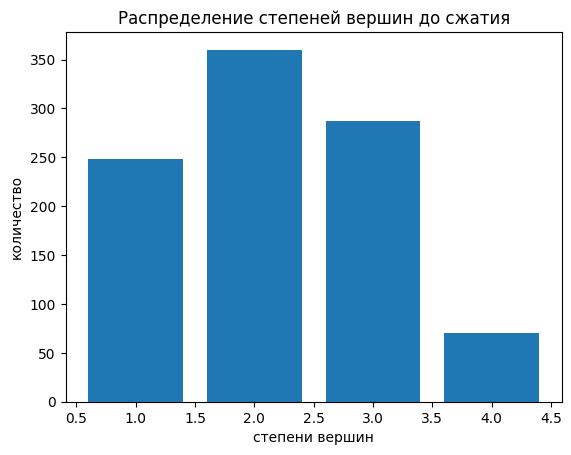

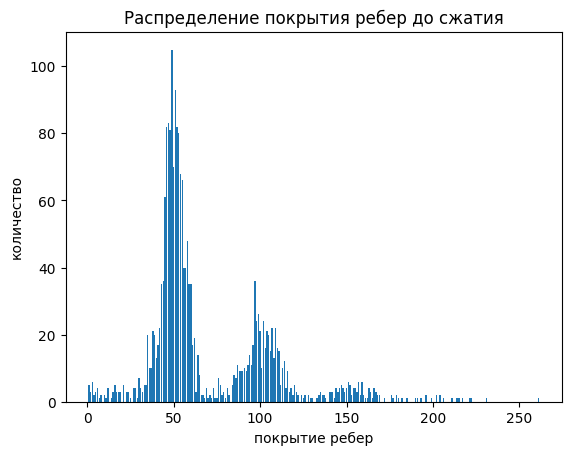

In [ ]:
kmers, edges, anti = build_de_bruijn_graph(reads, 5)
graph_info(kmers, edges, 'до')

Количество вершин после сжатия 798
Количество ребер после сжатия 1787


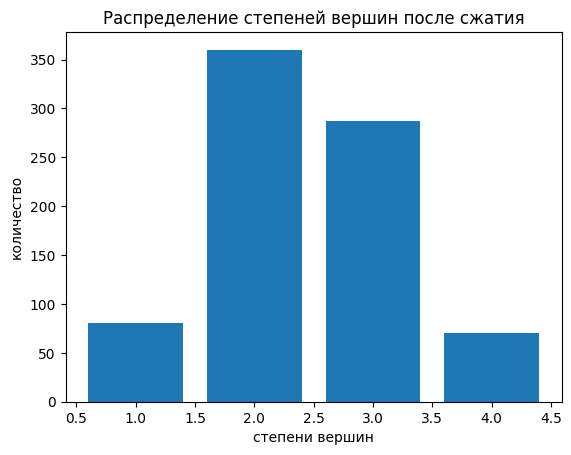

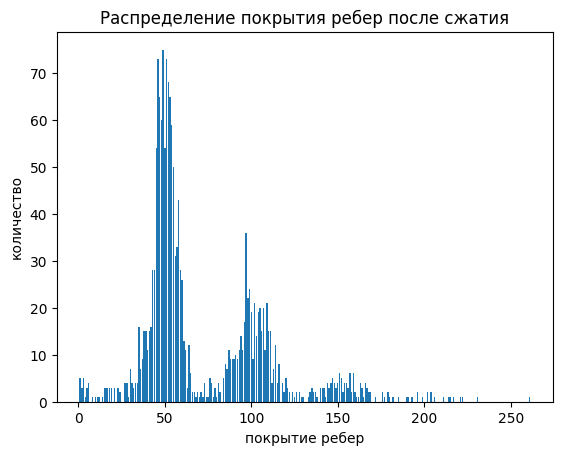

In [ ]:
kmers, compressed_edges, compressed_anti = compress_graph(kmers, edges, anti)
kmers, edges, anti = remove_low_coverage_tails(kmers, compressed_edges, compressed_anti)
graph_info(kmers, edges, 'после')

На синтетических данных удаляется около 150 вершин и порядка 300 ребер.

##Реальные данные

Исходный фаста-файл был триммирован и обработан для коррекции ошибок в BFC

java -jar /home/sveta/soft/Trimmomatic-0.39/trimmomatic-0.39.jar SE /home/sveta/Загрузки/sequenced_reads.fastq trimmed_reads.fastq SLIDINGWINDOW:4:2 LEADING:3 TRAILING:3 MINLEN:36

git checkout -b Bioinformatics_Zabarina_HW2-1

./bfc  -k 21 -t 4 /home/sveta/Загрузки/sequenced_reads_1.fastq > /home/sveta/Загрузки/corrected_output.fasta




In [15]:
from Bio import SeqIO

In [16]:
input_fastq = "filtered_output.fasta"
output_fasta = "small.fasta"
a_value = 0.5

with open(input_fastq, "r") as infile, open(output_fasta, "w") as outfile:
    for record in SeqIO.parse(infile, "fasta"):
        if random.random() < 0.3:
            SeqIO.write(record, outfile, "fasta")

In [17]:
def build_de_bruijn_graph( name, k=20):
    edges = dict()  # ребра из ридов с покрытиями

    with open(name) as handle:
        for record in SeqIO.parse(handle, "fasta"):
            read = str(record.seq)
            for i in range(len(read) - k):
                edge_seq = read[i:i + k + 1]
                if edge_seq not in edges.keys():
                    edges[edge_seq] = 0
                edges[edge_seq] += 1
    kmers = defaultdict(KMer)
    class_edges = defaultdict(list)
    anti_edges = defaultdict(list)

    for kmer, count in edges.items():
        kmer1, kmer2 = kmer[:-1], kmer[1:]
        if kmer1 not in kmers:
            kmers[kmer1] = KMer()
        if kmer2 not in kmers:
            kmers[kmer2] = KMer()
        kmers[kmer1].out_degree += 1
        kmers[kmer2].in_degree += 1
        if kmer1 in class_edges.keys():
            class_edges[kmer1].append(Edge(kmer, count))
        else:
            class_edges[kmer1] = [Edge(kmer, count)]
        if kmer2 in anti_edges.keys():
            anti_edges[kmer2].append(Edge(kmer, count))
        else:
            anti_edges[kmer2] = [Edge(kmer, count)]
    return kmers, class_edges, anti_edges

In [ ]:
kmers, edges, anti = build_de_bruijn_graph(output_fasta, 20)
graph_info(kmers, edges, 'до')

In [ ]:
kmers, compressed_edges, compressed_anti = compress_graph(kmers, edges, anti)
kmers, edges, anti = remove_low_coverage_tails(kmers, compressed_edges, compressed_anti)
graph_info(kmers, edges, 'после')